In [1]:
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
players = pd.read_csv("../processed_data/clean/players.csv",index_col = 0)
players.head()

,height,weight,birthDate,collegeName,position,displayName
nflId,,,,,,
2539334,1.83,86,1990-09-10,Washington,CB,Desmond Trufant
2539653,1.78,84,1988-11-01,Southeastern Louisiana,CB,Robert Alford
2543850,1.75,84,1991-12-18,Purdue,SS,Ricardo Allen
2555162,1.85,103,1994-11-04,Louisiana State,MLB,Deion Jones
2555255,1.91,105,1993-07-01,Minnesota,OLB,De'Vondre Campbell


In [4]:
summary = pd.read_csv("summary.csv",index_col=0)
summary

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
0,71251.0,2018093006:2225:4,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
1,89756.0,2018093006:2225:4,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
2,494287.0,2018093006:2225:4,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
3,2533062.0,2018093006:2225:4,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
4,2541243.0,2018093006:2225:4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2550164.0,2018120902:699:14,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
753,2552389.0,2018120902:699:14,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
754,2555166.0,2018120902:699:14,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
755,2555540.0,2018120902:699:14,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1


In [5]:
len(summary[summary["defenseValoration"]==0])/len(summary)

0.44596912521440824

In [6]:
len(summary[summary["defenseValoration"]==1])/len(summary)

0.5540308747855918

# Cambiar valor gameClock

In [7]:
from datetime import datetime
s1 = "15:00:00"
s2 = "03:29:00"
format = "%M:%S:%f"
time = datetime.strptime(s1, format) - datetime.strptime(s2, format)
print(time.total_seconds())
print(str(time).split(":"))

691.0
['0', '11', '31']


In [8]:
def changeGameClock(value,quarter):
    if quarter == 1:
        total_time = 3600
    elif quarter == 2:
        total_time = 2700
    elif quarter == 3:
        total_time = 1800
    elif quarter == 4:
        total_time = 900
    
    format = "%M:%S:%f"
    actual_time = datetime.strptime(value, format) - datetime.strptime("00:00:00",format)
    time = total_time - (900 - actual_time.total_seconds())
    return time

In [9]:
changeGameClock("00:07:00",2)

1807.0

In [10]:
summary_cp = summary.copy()

In [11]:
summary_cp["gameClock"] = summary_cp.apply(lambda x: changeGameClock(x["gameClock"],x["quarter"]),axis=1)

In [12]:
summary_cp.drop(["playerId","playId"],axis=1,inplace=True)

In [13]:
summary_cp

,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
0,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
1,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
2,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
3,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
753,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
754,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
755,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1


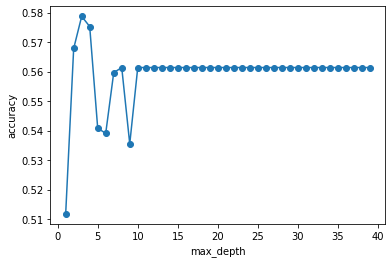

In [14]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(summary_cp))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:5.5,1:4.4}
                                            )
    for train_fold, test_fold in cv.split(summary_cp):
        f_train = summary_cp.iloc[train_fold]
        f_test = summary_cp.iloc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['defenseValoration'], axis=1), 
                               y = f_train['defenseValoration'])
        test_acc = model.score(X = f_test.drop(['defenseValoration'], axis=1), 
                                y = f_test['defenseValoration'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.3)

In [16]:
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25],'min_samples_split':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
             'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],'splitter':["best","random"],
              'class_weight':[{0:5.5,1:4.4},{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:2}]}
tree_model = tree.DecisionTreeClassifier()
clf = GridSearchCV(tree_model, tree_param)

In [17]:
clf.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 5.5, 1: 4.4}, {0: 1, 1: 1},
                                          {0: 2, 1: 1}, {0: 3, 1: 1},
                                          {0: 4, 1: 2}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17,
                                       18, 19, 20, 21, 22, 23, 24, 25],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30],
                         'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18,
                                               20, 22, 24, 26, 28, 30],
                         'splitter': ['best', 'random']})

In [18]:
clf.best_params_

{'class_weight': {0: 5.5, 1: 4.4},
 'criterion': 'entropy',
 'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}

In [23]:
len(summary.columns)

22

Modelo gridsearch

In [47]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 11,min_samples_leaf=1,min_samples_split=2,splitter="random")
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.9542857142857143


con 25 es demasiado

In [48]:
#save model
pickle_file = open('model_gridsearch.pickle','wb')
pickle.dump(regressor,pickle_file)
pickle_file.close()

In [41]:
from sklearn.model_selection import RandomizedSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25],'min_samples_split':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
             'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],'splitter':["best","random"],
              'class_weight':[{0:5.5,1:4.4},{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:2}]}
tree_model = tree.DecisionTreeClassifier()
clf = RandomizedSearchCV(tree_model, tree_param)

In [42]:
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'class_weight': [{0: 5.5, 1: 4.4},
                                                         {0: 1, 1: 1},
                                                         {0: 2, 1: 1},
                                                         {0: 3, 1: 1},
                                                         {0: 4, 1: 2}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 15, 16, 17, 18, 19,
                                                      20, 21, 22, 23, 24, 25],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                    

In [43]:
clf.best_params_

{'splitter': 'best',
 'min_samples_split': 4,
 'min_samples_leaf': 14,
 'max_depth': 24,
 'criterion': 'gini',
 'class_weight': {0: 5.5, 1: 4.4}}

Modelo randomsearch

In [44]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='gini', max_depth = 24,min_samples_leaf=14,min_samples_split=4,splitter="best")
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8971428571428571


In [45]:
#save model
pickle_file = open('model_random.pickle','wb')
pickle.dump(regressor,pickle_file)
pickle_file.close()

Modelo normal

In [46]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65, 
                                  min_samples_leaf = 20, max_depth = 10, 
                                  class_weight={0:5.5,1:4.4})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.84


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.85135135 0.14864865]
 [0.18811881 0.81188119]]


TypeError: 'str' object is not callable

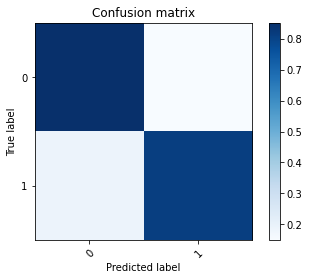

In [23]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

In [47]:
#save model
pickle_file = open('first_model.pickle','wb')
pickle.dump(regressor,pickle_file)
pickle_file.close()

In [19]:
#load model
pickle_file = open('first_model.pickle','rb')
regressor = pickle.load(pickle_file)
pickle_file.close()

In [19]:
summary_cp.head()

,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
0,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
1,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
2,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
3,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0


In [54]:
predict_proba = regressor.predict_proba(summary_cp.drop(["defenseValoration"],axis=1))[:,1]

Valor = predict_proba - (1- predict_proba)

In [55]:
summary["predict_proba"] = predict_proba - (1 - predict_proba)
summary

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
0,71251.0,2018093006:2225:4,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,-1.0
1,89756.0,2018093006:2225:4,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,-1.0
2,494287.0,2018093006:2225:4,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,-1.0
3,2533062.0,2018093006:2225:4,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,-1.0
4,2541243.0,2018093006:2225:4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2550164.0,2018120902:699:14,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,1.0
753,2552389.0,2018120902:699:14,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,1.0
754,2555166.0,2018120902:699:14,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,1.0
755,2555540.0,2018120902:699:14,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,1.0


In [56]:
predict_proba_sums = summary.groupby("playerId")["predict_proba"].sum()
predict_proba_sums

playerId
1302.0       0.000000
2307.0      -0.287129
2354.0       1.438202
4365.0      -0.088114
71251.0     -1.526316
               ...   
2561042.0    1.000000
2561117.0   -0.287129
2561132.0    1.000000
2561318.0   -1.000000
2561644.0    1.000000
Name: predict_proba, Length: 284, dtype: float64

In [57]:
valoration_players = {}
for player in predict_proba_sums.index:
    valoration_players[players.loc[player]["displayName"]] = predict_proba_sums[player]

In [58]:
dict(sorted(valoration_players.items(), key=lambda item: item[1],reverse=True))

{'Danny Trevathan': 2.473684210526316,
 'Darian Stewart': 2.372384937238494,
 'Brandon Marshall': 2.372384937238494,
 'Bradley Roby': 2.372384937238494,
 'Vonn Bell': 2.372384937238494,
 'Justin Simmons': 2.372384937238494,
 'Will Parks': 2.372384937238494,
 'Isaac Yiadom': 2.372384937238494,
 'Kyle Fuller': 2.186555497655029,
 'Adrian Amos': 2.186555497655029,
 'Eddie Jackson': 2.186555497655029,
 'Sam Shields': 2.0,
 'Buster Skrine': 2.0,
 'Trumaine Johnson': 2.0,
 'Jamie Collins': 2.0,
 'Nickell Robey-Coleman': 2.0,
 'Lamarcus Joyner': 2.0,
 'Terrance Mitchell': 2.0,
 'T.J. Carrie': 2.0,
 'Damarious Randall': 2.0,
 'Joe Schobert': 2.0,
 'Marqui Christian': 2.0,
 'Briean Boddy-Calhoun': 2.0,
 'Cory Littleton': 2.0,
 'Alex Anzalone': 2.0,
 'John Johnson': 2.0,
 'Mason Foster': 1.8105871844295054,
 'Josh Norman': 1.8105871844295054,
 'D.J. Swearinger': 1.8105871844295054,
 'Eli Apple': 1.8105871844295054,
 'Dre Kirkpatrick': 1.473684210526316,
 'William Jackson': 1.473684210526316,
 'J

In [53]:
#save model
pickle_file = open('predict_proba.pickle','wb')
pickle.dump(predict_proba,pickle_file)
pickle_file.close()

In [65]:
defense = pd.read_csv("all_players_plays.csv",index_col=0)
defense

,displayName,good,bad,total_plays,Plus/Minus,ratio
id,,,,,,
2543681,Kyle Fuller,95,48,143,47,0.664336
2552385,Adrian Amos,94,48,142,46,0.661972
2560851,Justin Reid,75,60,135,15,0.555556
2540180,Tyrann Mathieu,77,56,133,21,0.578947
496735,Kareem Jackson,76,57,133,19,0.571429
...,...,...,...,...,...,...
2560815,Kam Moore,1,0,1,1,1.000000
2561283,Zeke Turner,1,0,1,1,1.000000
2541431,Kemal Ishmael,0,1,1,-1,0.000000


In [63]:
valoration_players = {}
for player in predict_proba_sums.index:
    valoration_players[player] = predict_proba_sums[player]

In [67]:
def obtainValoration(playerId):
    try:
        value = valoration_players[playerId]
    except KeyError:
        value = 0
    return value

In [68]:
defense["Valoration"] = defense.index.map(obtainValoration)

In [69]:
defense

,displayName,good,bad,total_plays,Plus/Minus,ratio,Valoration
id,,,,,,,
2543681,Kyle Fuller,95,48,143,47,0.664336,2.186555
2552385,Adrian Amos,94,48,142,46,0.661972,2.186555
2560851,Justin Reid,75,60,135,15,0.555556,1.000000
2540180,Tyrann Mathieu,77,56,133,21,0.578947,1.000000
496735,Kareem Jackson,76,57,133,19,0.571429,1.000000
...,...,...,...,...,...,...,...
2560815,Kam Moore,1,0,1,1,1.000000,0.000000
2561283,Zeke Turner,1,0,1,1,1.000000,0.000000
2541431,Kemal Ishmael,0,1,1,-1,0.000000,0.000000


In [71]:
summary[summary["playerId"]==2543681]

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
110,2543681.0,2018101404:1249:6,2.306198,5.685909,1.000000,0.300000,-87.30755,2,1,5,-0.080176,1.47,-30.05,0.0,7.0,0.0,3,2,5,78.0,07:16:00,1,0.473684
361,2543681.0,2018121603:1293:15,1.755946,1.398143,1.000000,1.000000,107.85180,1,1,6,0.064904,5.63,-16.03,0.0,7.0,0.0,3,2,9,33.0,07:37:00,1,1.000000
524,2543681.0,2018093001:1634:4,5.447380,2.038283,0.423077,1.363636,-39.23960,1,0,5,-0.152907,3.03,-23.03,0.0,28.0,3.0,3,2,7,82.0,08:20:00,1,1.000000
608,2543681.0,2018111802:4426:11,5.302089,5.459386,0.433333,0.166667,-0.47755,1,0,5,-12.564129,1.99,-28.37,1.0,25.0,14.0,3,4,3,47.0,01:59:00,0,-0.287129


In [73]:
summary[summary["playerId"]==2558176]

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
113,2558176.0,2018101404:1249:6,16.822337,13.314722,0.000000,0.0,-87.30755,2,1,5,-0.080176,1.47,-30.05,0.0,7.0,0.0,3,2,5,78.0,07:16:00,1,0.473684
363,2558176.0,2018121603:1293:15,8.326847,2.149432,0.214286,1.0,107.85180,1,1,6,0.064904,5.63,-16.03,0.0,7.0,0.0,3,2,9,33.0,07:37:00,1,1.000000
527,2558176.0,2018093001:1634:4,17.957479,13.171563,0.000000,0.0,-39.23960,1,0,5,-0.152907,3.03,-23.03,0.0,28.0,3.0,3,2,7,82.0,08:20:00,1,1.000000
611,2558176.0,2018111802:4426:11,8.965735,2.214395,0.133333,1.0,-0.47755,1,0,5,-12.564129,1.99,-28.37,1.0,25.0,14.0,3,4,3,47.0,01:59:00,0,-0.287129


In [70]:
defense.to_csv("all_players_plays.csv")

In [81]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.2)

In [82]:
from sklearn.ensemble import RandomForestClassifier

#1.1 Model Parametrization 
regressor = RandomForestClassifier(n_estimators= 100, max_depth = 10, random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_test)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 1.0


Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


TypeError: 'str' object is not callable

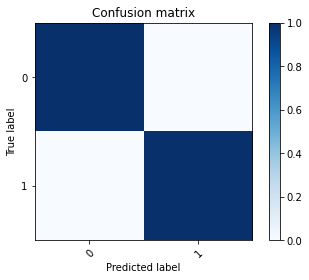

In [83]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

# Normalización de los datos

In [ ]:
scaler = preprocessing.StandardScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.MinMaxScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.RobustScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.PowerTransformer()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))